In [1]:
import numpy as np
import mpiutil
import pickle, os
from linear_solver import cg, pytorch_lin_solver
from scipy.linalg import solve

from pygdsm import GlobalSkyModel
from full_Gibbs_sampler import full_Gibbs_sampler_multi_TODS

from TOD_simulator import TOD_sim
import time 
import logging

# Configure logging to print to the console
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Optionally, configure logging to write to a file
# logging.basicConfig(filename='/Users/zzhang/Workspace/flicker/logfile.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

start_time = time.time()
# Antenna position: Latitude: -30.7130° S; Longitude: 21.4430° E.

# Save the "local_TOD" objects
savepath = "/Users/zzhang/Dataspace/flicker/"
# savepath = "/Users/user/TOD_simulations/"
TOD_savename = "TOD_sim_{}.pkl".format(mpiutil.rank)
# combind the savepath and savename
TOD_savepath = os.path.join(savepath, TOD_savename)

# If TOD_savepath exists, directly read it
if os.path.exists(TOD_savepath):
    with open(TOD_savepath, 'rb') as f:
        local_TOD = pickle.load(f)

2025-03-27 22:29:14,022 - INFO - 0.0 180.0 -180.0 180.0
2025-03-27 22:29:14,022 - INFO - The interval between parallels is 30 deg -0.00'.
2025-03-27 22:29:14,023 - INFO - The interval between meridians is 30 deg -0.00'.


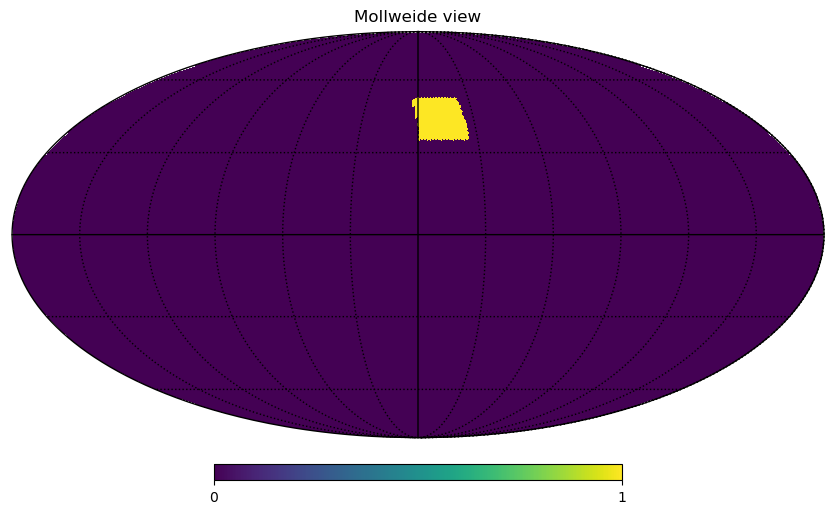

In [2]:
import healpy as hp

hp.mollview(local_TOD.full_bool_map)
hp.graticule()

In [3]:
np.sum(local_TOD.full_bool_map)

np.int64(377)

In [4]:
local_TOD.local_TOD_list[0].shape

(2640,)

In [5]:
local_TOD.nside

512

In [8]:
from pygdsm import GlobalSkyModel

gsm = GlobalSkyModel()
skymap = gsm.generate(500)

skymap_64 = hp.ud_grade(skymap, nside_out=64)
hp.get_nside(skymap_64)

64

In [16]:
import numpy as np
import cmath
from scipy.integrate import quad

def gamma_inc_1(z, R, epsabs=1e-6, epsrel=1e-6):
    """Calculate the vectorized line integral of the incomplete gamma function.
    Parameters:
        z (complex): Complex (or just real) variable.  
        R (float or array_like): Positive real number or array.
        epsabs (float): Absolute error tolerance.
        epsrel (float): Relative error tolerance.
    Returns:
        complex or ndarray: Complex result (same shape as R).
    """
    R = np.asarray(R) 
    
    # function for single input R
    def _integral_single(R_val):
        if R_val <= 0:
            raise ValueError("R must be positive")
        
        def integrand_real(t):
            s = 1j * R_val + t
            val = cmath.exp(-s) * (s ** (z - 1))
            return val.real
        
        def integrand_imag(t):
            s = 1j * R_val + t
            val = cmath.exp(-s) * (s ** (z - 1))
            return val.imag
        
        real_part, _ = quad(integrand_real, 0, np.inf, epsabs=epsabs, epsrel=epsrel)
        imag_part, _ = quad(integrand_imag, 0, np.inf, epsabs=epsabs, epsrel=epsrel)
        return real_part + 1j * imag_part
    
    # Vectorize the function
    vfunc = np.vectorize(_integral_single, otypes=[np.complex128])
    return vfunc(R)

In [ ]:
import mpiutil
from joblib import delayed
def gamma_inc_list(z, R_vals, epsabs=1e-6, epsrel=1e-6):
    """Calculate the vectorized line integral of the incomplete gamma function.
    Parameters:
        z (complex): Complex (or just real) variable.  
        R (float or array_like): Positive real number or array.
        epsabs (float): Absolute error tolerance.
        epsrel (float): Relative error tolerance.
    Returns:
        complex or ndarray: Complex result (same shape as R).
    """
    R_vals = np.asarray(R_vals) 
    
    # function for single input R
    def _integral_single(R_val):
        if R_val <= 0:
            raise ValueError("R must be positive")
        
        def integrand(t):
            s = 1j * R_val + t
            val = cmath.exp(-s) * (s ** (z - 1))
            return val
        
        result, _ = quad(integrand, 0, np.inf, epsabs=epsabs, epsrel=epsrel, complex_func=True)
        return result
    
    # Vectorize the function
    # vfunc = np.vectorize(_integral_single, otypes=[np.complex128])
    # return vfunc(R)

    # Or Parallelize the function:
    return np.array(mpiutil.local_parallel_pool(delayed(_integral_single)(iR)   for iR in R_vals))

    

In [ ]:
gamma_inc_1(-1, 0.0000)

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_59942/143602711.py:32: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  real_part, _ = quad(integrand_real, 0, np.inf, epsabs=epsabs, epsrel=epsrel)
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_59942/143602711.py:33: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  imag_part, _ = quad(integrand_imag, 0, np.inf, epsabs=epsabs, epsrel=epsrel)


array(-7.54785793+0.00778623j)

In [15]:
gamma_inc_2(-1, [0.002])

array([-6.63739277-498.43020367j])